In [117]:
import pdal
import json
import geopandas
import pandas as pd
from shapely.geometry import Polygon, Point, mapping
import numpy as np
from pyproj import Proj, transform
import folium
import laspy as lp

import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [118]:
# loading json file
def read_json(json_path):
    try:
        with open(json_path) as js:
            json_obj = json.load(js)
        return json_obj

    except FileNotFoundError:
        print('File not found.')


In [119]:


def convert_EPSG(fromT, lon, lat):
    P3857 = Proj(init='epsg:3857')
    P4326 = Proj(init='epsg:4326')
    if(fromT == 4326):
        input1 = P4326
        input2 = P3857
    else:
        input1=p3857
        input2=p4326
        
    x, y = transform(input1,input2, lon, lat)
    return [x, y]
    
def loop_EPSG_converter(listin):
    converted = []
    for item in listin:
        converted.append(convert_EPSG(4326, item[0], item[1]))
        
    return converted

In [120]:
def generate_polygon(coor, epsg):
    polygon_g = Polygon(coor)
    crs = {'init': 'epsg:'+str(epsg)}
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_g])       
    return polygon

In [121]:
def generate_geo_df(pipe, epsg):
    try:
        cloud_points = []
        elevations =[]
        geometry_points=[]
        for row in pipe.arrays[0]:
            lst = row.tolist()[-3:]
            cloud_points.append(lst)
            elevations.append(lst[2])
            point = Point(lst[0], lst[1])
            geometry_points.append(point)
        geodf = geopandas.GeoDataFrame(columns=["elevation", "geometry"])
        geodf['elevation'] = elevations
        geodf['geometry'] = geometry_points
        geodf = geodf.set_geometry("geometry")
        geodf.set_crs(epsg = epsg, inplace=True)
        return geodf
    except RuntimeError as e:
        self.logger.exception('fails to extract geo data frame')
        print(e)

In [165]:
coordinates = [
    [-93.756055, 41.918115],
    [-93.756155, 41.918215],
    [-93.756396, 41.918475],
    [-93.755955, 41.918300],
    [-93.755795, 41.918000],
]

In [166]:
polygon2 = generate_polygon(coordinates, 4326)

In [167]:

def show_on_map(polygon, zoom):
    #region selection
    poly = mapping((polygon2.iloc[:,0][0]))
    tmp = poly['coordinates'][0][0]
    anchor = [tmp[1], tmp[0]]
    m = folium.Map(anchor,zoom_start=zoom, tiles='cartodbpositron')
    folium.GeoJson(polygon).add_to(m)
    folium.LatLngPopup().add_to(m)
    return m

show_on_map(polygon2, 20)

In [168]:
coor = loop_EPSG_converter(coordinates)
print(coor)
polygon = generate_polygon(coor, 4326)

[[-10436876.301386151, 5148721.349314567], [-10436887.43333523, 5148736.309605352], [-10436914.26133251, 5148775.206471106], [-10436865.169437071, 5148749.025870951], [-10436847.358318545, 5148704.145009145]]


In [169]:

def modify_pipe_json(json_loc, url, region, in_epsg, out_epsg):
    dicti = read_json(json_loc)
    dicti['pipeline'][0]['polygon'] = str(polygon.iloc[:,0][0])
    dicti['pipeline'][0]['filename'] = f"{url}/{region}/ept.json"
    dicti['pipeline'][2]['in_srs'] = f"EPSG:{in_epsg}"
    dicti['pipeline'][2]['out_srs'] = f"EPSG:{out_epsg}"
    print(dicti)
    return dicti
    
location = "pdal.json"
url = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public"
region = "IA_FullState"
in_srs = 3857
out_srs = 4326

request = modify_pipe_json(location, url, region, in_srs, out_srs)


{'pipeline': [{'polygon': 'POLYGON ((-10436876.301386151 5148721.349314567, -10436887.43333523 5148736.309605352, -10436914.26133251 5148775.206471106, -10436865.169437071 5148749.025870951, -10436847.358318545 5148704.145009145, -10436876.301386151 5148721.349314567))', 'filename': 'https://s3-us-west-2.amazonaws.com/usgs-lidar-public/IA_FullState/ept.json', 'type': 'readers.ept', 'tag': 'readdata'}, {'type': 'filters.range', 'limits': 'Classification![7:7]', 'tag': 'no_noise'}, {'in_srs': 'EPSG:3857', 'out_srs': 'EPSG:4326', 'tag': 'reprojectUTM', 'type': 'filters.reprojection'}, {'filename': 'iowa.csv', 'tag': 'writerscsv', 'type': 'writers.text'}, {'filename': 'iowa.las', 'tag': 'writersply', 'type': 'writers.las'}]}


In [170]:
pipe = pdal.Pipeline(json.dumps(request))

In [171]:
pipe.execute()

1371

In [172]:
df = generate_geo(pipe, 4326)

Text(88.875, 0.5, 'Latitude')

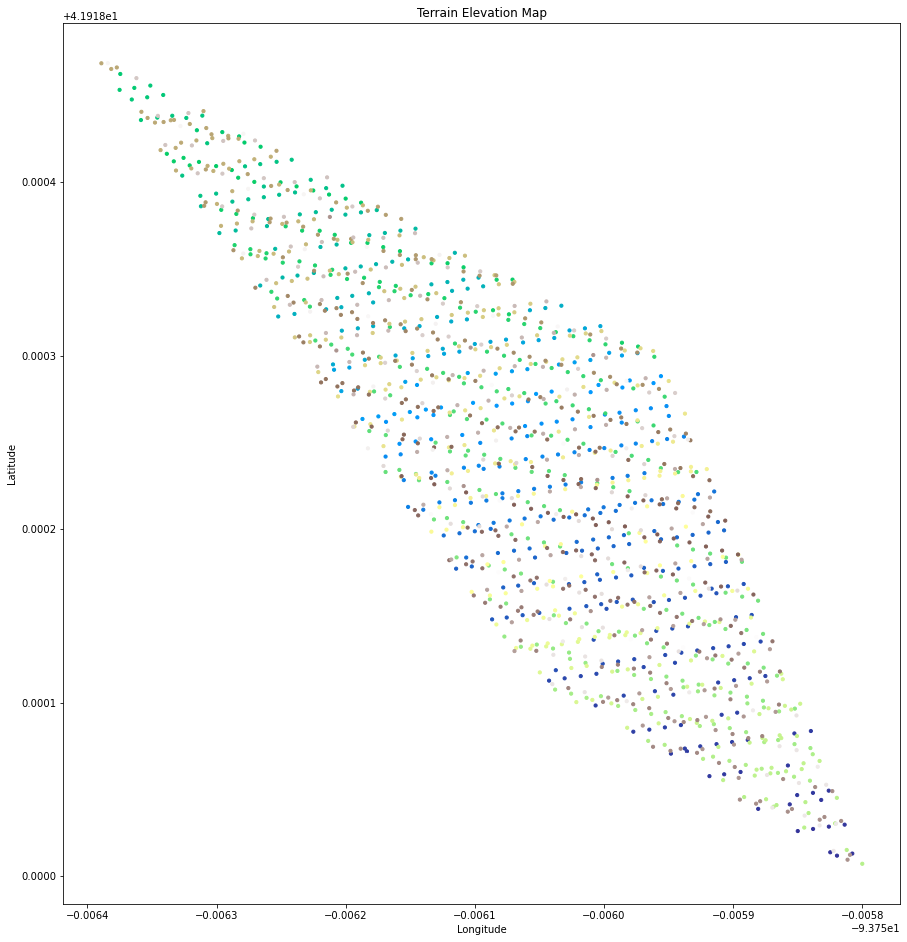

In [173]:
df.plot(c='elevation', scheme="quantiles", cmap='terrain', legend=True,
                                  markersize=10,
                                  figsize=(15, 20),
                                  missing_kwds={
                                    "color": "lightgrey",
                                    "edgecolor": "red",
                                    "hatch": "///",
                                    "label": "Missing values"}
                                  )

plt.title('Terrain Elevation Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [174]:
point_cloud = lp.read("iowa.las")
point_cloud

<LasData(1.2, point fmt: <PointFormat(3, 0 bytes of extra dims)>, 1371 points, 3 vlrs)>

In [175]:
points = np.vstack((point_cloud.x, point_cloud.y, point_cloud.z)).transpose()

In [176]:
voxel_size=6
nb_vox=np.ceil((np.max(points, axis=0) - np.min(points, axis=0))/voxel_size)
non_empty_voxel_keys, inverse, nb_pts_per_voxel = np.unique(((points - np.min(points, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
idx_pts_vox_sorted=np.argsort(inverse)
nb_vox

array([0., 0., 1.])

In [177]:
voxel_grid={}
grid_barycenter,grid_candidate_center=[],[]
last_seen=0
for idx,vox in enumerate(non_empty_voxel_keys):
    voxel_grid[tuple(vox)]= points[idx_pts_vox_sorted[
    last_seen:last_seen+nb_pts_per_voxel[idx]]]
    grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))
    grid_candidate_center.append(
    voxel_grid[tuple(vox)][np.linalg.norm(voxel_grid[tuple(vox)] -
    np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()])
    last_seen+=nb_pts_per_voxel[idx]
    
voxel_grid

{(0,
  0,
  0): array([[-93.76,  41.92, 310.31],
        [-93.76,  41.92, 310.19],
        [-93.76,  41.92, 310.2 ],
        ...,
        [-93.76,  41.92, 310.33],
        [-93.76,  41.92, 310.2 ],
        [-93.76,  41.92, 310.53]])}

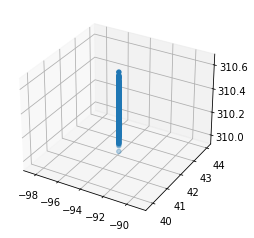

In [179]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


ax = plt.axes(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2])
plt.show()